#Single product and stochastic environment

Parameters :

*   T rounds
*   N number of types of products
*   P set of possible prices
*   B prduction capacity



In [1]:
import numpy as np
import matplotlib.pyplot as plt

stochastic environment for our regret :

In [2]:
conversion_probability = lambda p: 1-p/20

In [3]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t


In [4]:
env = PricingEnvironment(conversion_probability=conversion_probability, cost=5)
env.round(10, 100)

(46, 230)

##1. Single product and no inventory constraints

In [5]:
#MA prob we just need to discretize the arms

class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    # need to play each arm once then update the upper confidence bound
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

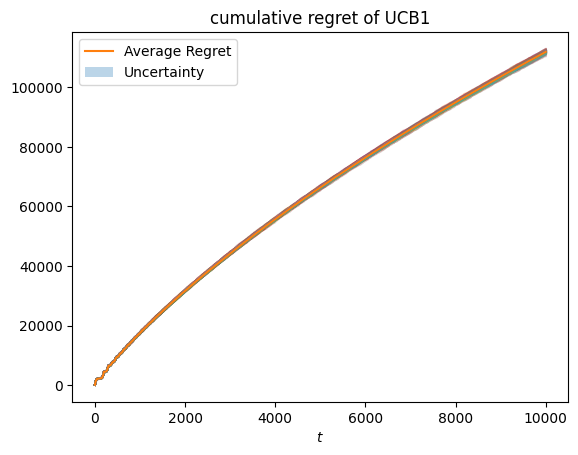

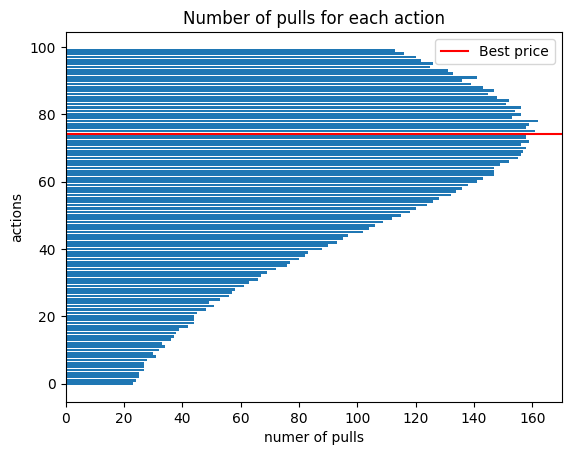

In [12]:
T = 10000
K = 100

prices = np.linspace(10,20,K) # 100 actions!
cost = 15
conversion_probability = lambda p: 1-p/20

n_customers = 30 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

# Track reward for each round
clairvoyant_rewards = []
for t in range(T):
    # simulate number of sales at the best price
    n_sales = np.random.binomial(n_customers, conversion_probability(best_price))
    reward = reward_function(best_price, n_sales)
    clairvoyant_rewards.append(reward)

clairvoyant_rewards = np.array(clairvoyant_rewards)

n_trials = 100

regret_per_trial = []
regret_ratio_trials = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])
    regret_per_trial_ratio = []
    cr_per_round = 0

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

        diff = clairvoyant_rewards[t] - agent_rewards[t]
        cr_per_round += diff
        regret_per_trial_ratio.append(cr_per_round/(t+1))


    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    regret_ratio_trials.append(np.sum(regret_per_trial_ratio) / len(regret_per_trial_ratio))

regret_per_trial = np.array(regret_per_trial)
avg_regret_ratio = np.sum(regret_ratio_trials) / len(regret_ratio_trials)
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

for i in range(n_trials):
    plt.plot(np.arange(T), regret_per_trial[i], alpha=0.3)
plt.plot(np.arange(T), average_regret)
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();


## 2. Adding inventory constraints

In [8]:
#MA prob we just need to discretize the arms

class UCB1Agent_constraints:
    def __init__(self, K, I, T, range=1):
        self.K = K
        self.T = T
        self.inventory = I
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    # need to play each arm once then update the upper confidence bound
    def pull_arm(self):
        if self.inventory < 1:
            self.a_t = -1 # Use a special value to indicate no arm was pulled for pricing
            return 0 # Return a price that results in no sales (e.g., index 0 or a very high price)
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t, d_t):
        if self.a_t != -1: # Only update if a valid arm was pulled
            self.N_pulls[self.a_t] += 1
            self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
            self.inventory -= min(d_t, self.inventory)
        self.t += 1

/tmp/ipython-input-2652101959.py:22: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)


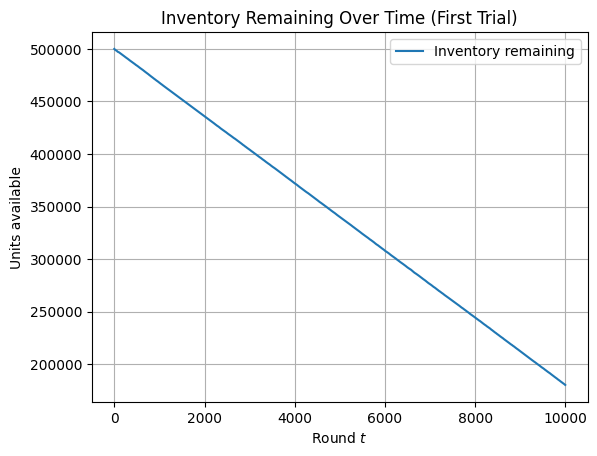

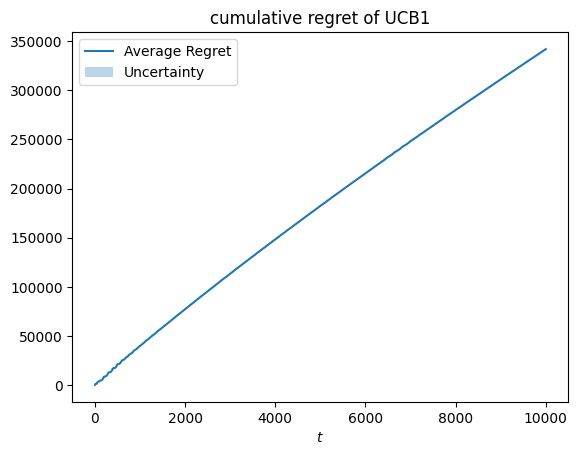

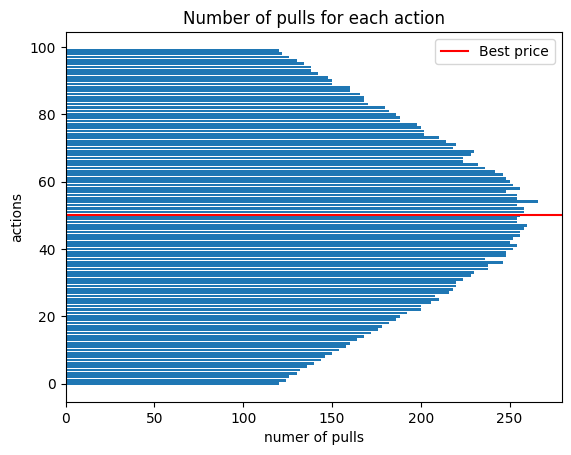

In [15]:
T = 10000
K = 100

prices = np.linspace(10,20,K) # 100 actions!
cost = 10
conversion_probability = lambda p: 1-p/20

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)
I = 500000 ## if we put 100000 we get same results with no constraints

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent_constraints(K, I, T, range=maximum_profit)

    agent_rewards = np.array([])
    inventory_over_time = []

    cumulative_regret = 0
    regret_ratio_per_trial = []

    for t in range(T):
        pi_t_index = ucb_agent.pull_arm() ## the agent returns the index!!
        if pi_t_index != -1: # Check if a valid arm was pulled
            p_t = prices[pi_t_index] # I get the actual price
            demanded_d_t, r_t = env.round(p_t, n_customers)
            actual_d_t = min(demanded_d_t, ucb_agent.inventory)
            ucb_agent.update(r_t, actual_d_t)


        else:
            p_t = prices[0] # Or any price that would result in 0 sales
            d_t = 0
            r_t = 0

        ucb_agent.update(r_t, d_t)
        inventory_over_time.append(ucb_agent.inventory)


        agent_rewards = np.append(agent_rewards, r_t)

    if seed == 0:
       first_inventory_over_time = inventory_over_time.copy()
       plt.figure()
       plt.plot(np.arange(T), first_inventory_over_time, label="Inventory remaining")
       plt.title("Inventory Remaining Over Time (First Trial)")
       plt.xlabel("Round $t$")
       plt.ylabel("Units available")
       plt.grid(True)
       plt.legend()
       plt.show()

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls) # Use K instead of 100 directly
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();


/tmp/ipython-input-2652101959.py:22: RuntimeWarning: divide by zero encountered in divide
  ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)


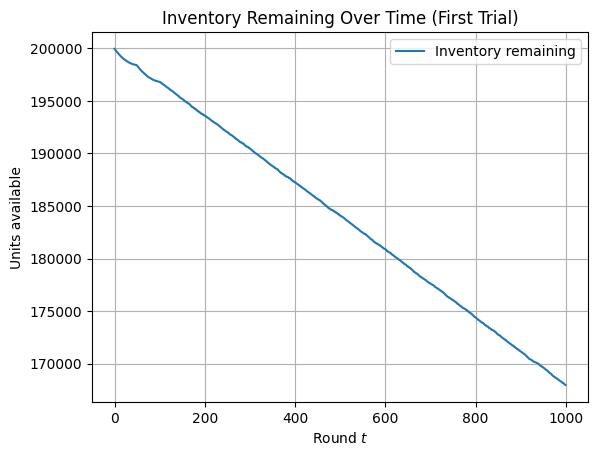

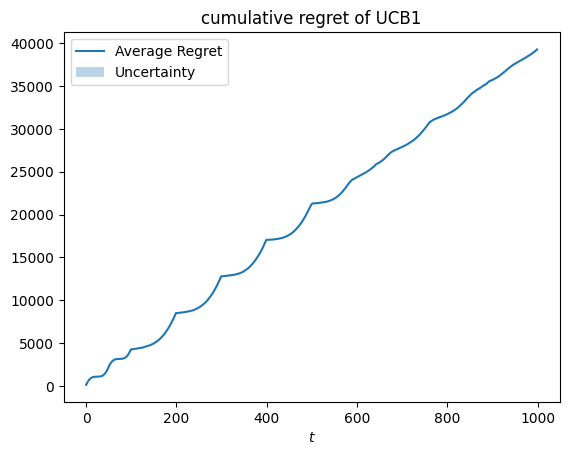

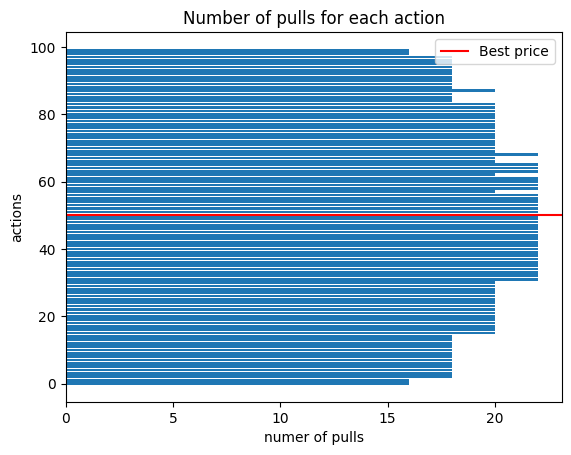

In [22]:
T = 1000
K = 100

prices = np.linspace(10,20,K) # 100 actions!
cost = 10
conversion_probability = lambda p: 1-p/20

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)
I = 200000 ## if we put 100000 we get same results with no constraints

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent_constraints(K, I, T, range=maximum_profit)

    agent_rewards = np.array([])
    inventory_over_time = []

    cumulative_regret = 0
    regret_ratio_per_trial = []

    for t in range(T):
        pi_t_index = ucb_agent.pull_arm() ## the agent returns the index!!
        if pi_t_index != -1: # Check if a valid arm was pulled
            p_t = prices[pi_t_index] # I get the actual price
            demanded_d_t, r_t = env.round(p_t, n_customers)
            actual_d_t = min(demanded_d_t, ucb_agent.inventory)
            ucb_agent.update(r_t, actual_d_t)


        else:
            p_t = prices[0] # Or any price that would result in 0 sales
            d_t = 0
            r_t = 0

        ucb_agent.update(r_t, d_t)
        inventory_over_time.append(ucb_agent.inventory)


        agent_rewards = np.append(agent_rewards, r_t)

    if seed == 0:
       first_inventory_over_time = inventory_over_time.copy()
       plt.figure()
       plt.plot(np.arange(T), first_inventory_over_time, label="Inventory remaining")
       plt.title("Inventory Remaining Over Time (First Trial)")
       plt.xlabel("Round $t$")
       plt.ylabel("Units available")
       plt.grid(True)
       plt.legend()
       plt.show()

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls) # Use K instead of 100 directly
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();
